# Faster python

In [23]:
%pylab inline

import numpy as np
import seaborn as sns

sns.set_style("whitegrid")
pylab.rcParams["figure.figsize"] = [12, 5]

Populating the interactive namespace from numpy and matplotlib


### Одномерное уравнение теплопроводности

In [51]:
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, cm


class HeatEquation(object):
    def __init__(
            self,
            x0=0,
            xN=math.pi,
            u0=math.sin,
            f=lambda t, x: math.cos(t / (x + 0.01)),
            a=1,
            N=1000,
            h=None,
            T=1000,
            tau=None
    ):
        self.x0 = x0
        self.xN = xN
        self.u0 = u0
        self.a = a
        self.N = N
        self.h = h if h else (xN - x0) / N
        # Feel bounds
        self._u0 = list(map(u0, map(lambda i: i * self.h, range(N + 1))))
        self.f = f
        self.T = T
        self.tau = self.h * self.h / 2

    def solve(self):
        grid = [self._u0]
        N = (self.N + 1)
        a = [-self.a / self.h ** 2] * (self.N)
        b = [1 / self.tau + 2 * self.a / self.h ** 2] * N
        for t in range(1, self.T):
            f = []
            for x in range(N):
                f.append(grid[-1][x] / self.tau + self.f(t * self.tau, x * self.h))
            grid.append(self.sweep(a, b, a, f))
        return grid

    @staticmethod
    def sweep(a, b, c, f):
        alpha = [-c[0] / b[0]]
        beta = [f[0] / b[0]]
        n = len(f)
        x = [0] * n
        for i in range(1, n - 1):
            m = (b[i] + a[i - 1] * alpha[i - 1])
            alpha.append(-c[i] / m)
            beta.append((f[i] - a[i - 1] * beta[i - 1]) / m)
        beta.append((f[-1] - a[-1] * beta[-1]) / (b[-1] + a[-1] * alpha[-1]))
        x[-1] = beta[-1]

        for i in reversed(range(n - 1)):
            x[i] = alpha[i] * x[i + 1] + beta[i]

        return x

    def solve_numpy(self):
        N = (self.N + 1)
        grid = np.zeros((self.T, N), dtype="float32")
        grid[0] = np.array(self._u0)
        a = np.zeros((self.N), dtype="float32")
        a[:] = -self.a / self.h ** 2
        b = np.zeros((N), dtype="float32")
        b[:] = 1.0 / self.tau + 2.0 * self.a / self.h ** 2.0
        for t in range(1, self.T):
            f = np.zeros((N))
            for x in range(N):
                f[x] = grid[-1][x] / self.tau + self.f(t * self.tau, x * self.h)
            grid[t] = self.sweep_numpy(a, b, a, f)
        return grid

    @staticmethod
    def sweep_numpy(a, b, c, f):
        alpha = np.zeros_like(a)
        alpha[0] = -c[0] / b[0]
        beta = np.zeros_like(f)
        beta[0] = f[0] / b[0]
        x = np.zeros(f.shape)
        for i in range(1, f.shape[0] - 1):
            m = (b[i] + a[i - 1] * alpha[i - 1])
            alpha[i] = -c[i] / m
            beta[i] = (f[i] - a[i - 1] * beta[i - 1]) / m
        beta[f.shape[0]-1] = (f[-1] - a[-1] * beta[-1]) / (b[-1] + a[-1] * alpha[-1])
        x[-1] = beta[-1]

        for i in reversed(range(f.shape[0] - 1)):
            x[i] = alpha[i] * x[i + 1] + beta[i]

        return x

    @staticmethod
    def plot(res, step=1):
        res = np.array(res)

        zmax = np.max(np.max(res)) + 0.01
        zmin = np.min(np.min(res)) - 0.01
        norm = colors.Normalize(vmin=zmin, vmax=zmax, clip=False)

        plt.imshow(res, interpolation='bilinear', cmap=cm.coolwarm, norm=norm)

    pass


In [52]:
he = HeatEquation()

In [53]:
%%timeit
res = he.solve()

1.41 s ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


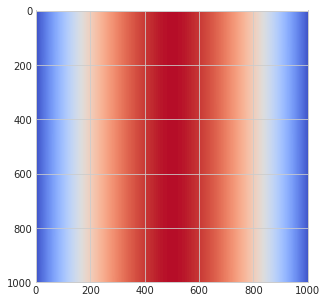

In [54]:
res = he.solve()
he.plot(res)

In [55]:
%%timeit
r = he.solve_numpy()

15.6 s ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### cProfile

In [56]:
import cProfile
source = open("heateq.py").read()
cProfile.run(source, sort="tottime") 

         5001010 function calls in 1.964 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      999    0.780    0.001    0.877    0.001 <string>:45(sweep)
        1    0.668    0.668    1.954    1.954 <string>:33(solve)
   999999    0.238    0.000    0.340    0.000 <string>:14(<lambda>)
  2997999    0.166    0.000    0.166    0.000 {method 'append' of 'list' objects}
   999999    0.103    0.000    0.103    0.000 {built-in method cos}
        1    0.008    0.008    1.963    1.963 <string>:2(<module>)
        1    0.001    0.001    1.964    1.964 {built-in method exec}
        1    0.000    0.000    0.000    0.000 <string>:9(__init__)
     1001    0.000    0.000    0.000    0.000 <string>:28(<lambda>)
      999    0.000    0.000    0.000    0.000 {built-in method len}
        1    0.000    0.000    0.000    0.000 {built-in method __build_class__}
        5    0.000    0.000    0.000    0.000 {built-in method hasattr}
        1

### line_profiler

In [57]:
%load_ext line_profiler

In [63]:
def solve(self):
    grid = [self._u0]
    N = (self.N + 1)
    a = [-self.a / self.h ** 2] * (self.N)
    b = [1 / self.tau + 2 * self.a / self.h ** 2] * N
    for t in range(1, self.T):
        f = []
        for x in range(N):
            f.append(grid[-1][x] / self.tau + self.f(t * self.tau, x * self.h))
        grid.append(self.sweep(a, b, a, f))
    return grid

In [64]:
%lprun -f solve solve(he)

### Cython

In [3]:
%load_ext Cython

In [172]:
%%cython
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, cm


class HeatEquation(object):
    def __init__(
            self,
            x0=0,
            xN=math.pi,
            u0=math.sin,
            f=lambda t, x: math.cos(t / (x + 0.01)),
            a=1,
            N=1000,
            h=None,
            T=1000,
            tau=None
    ):
        self.x0 = x0
        self.xN = xN
        self.u0 = u0
        self.a = a
        self.N = N
        self.h = h if h else (xN - x0) / N
        # Feel bounds
        self._u0 = list(map(u0, map(lambda i: i * self.h, range(N + 1))))
        self.f = f
        self.T = T
        self.tau = self.h * self.h / 2

    def solve(self):
        grid = [self._u0]
        N = (self.N + 1)
        a = [-self.a / self.h ** 2] * (self.N)
        b = [1 / self.tau + 2 * self.a / self.h ** 2] * N
        for t in range(1, self.T):
            f = []
            for x in range(N):
                f.append(grid[-1][x] / self.tau + self.f(t * self.tau, x * self.h))
            grid.append(self.sweep(a, b, a, f))
        return grid

    @staticmethod
    def sweep(a, b, c, f):
        alpha = [-c[0] / b[0]]
        beta = [f[0] / b[0]]
        n = len(f)
        x = [0] * n
        for i in range(1, n - 1):
            m = (b[i] + a[i - 1] * alpha[i - 1])
            alpha.append(-c[i] / m)
            beta.append((f[i] - a[i - 1] * beta[i - 1]) / m)
        beta.append((f[-1] - a[-1] * beta[-1]) / (b[-1] + a[-1] * alpha[-1]))
        x[-1] = beta[-1]

        for i in reversed(range(n - 1)):
            x[i] = alpha[i] * x[i + 1] + beta[i]

        return x

    pass


In [173]:
he = HeatEquation()

In [174]:
%%timeit
res = he.solve()

864 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### cimport and cdef

In [185]:
%%cython
import numpy as np

cimport cython
cimport numpy as np

@cython.nonecheck(False)
@cython.boundscheck(False)
@cython.overflowcheck(False)
cdef np.ndarray[double, ndim=1] sweep_numpy(np.ndarray[double, ndim=1] a,
                np.ndarray[double, ndim=1] b,
                np.ndarray[double, ndim=1] c,
                np.ndarray[double, ndim=1] f):
        cdef np.ndarray alpha = np.zeros_like(a)
        alpha[0] = -c[0] / b[0]
        cdef np.ndarray[double, ndim=1] beta = np.zeros_like(f, dtype=np.float)
        beta[0] = f[0] / b[0]
        cdef np.ndarray[double, ndim=1] x = np.zeros((len(f)), dtype=np.float)
        for i in range(1, f.shape[0] - 1):
            m = (b[i] + a[i - 1] * alpha[i - 1])
            alpha[i] = -c[i] / m
            beta[i] = (f[i] - a[i - 1] * beta[i - 1]) / m
        beta[f.shape[0]-1] = (f[-1] - a[-1] * beta[-1]) / (b[-1] + a[-1] * alpha[-1])
        x[-1] = beta[-1]

        for i in reversed(range(f.shape[0] - 1)):
            x[i] = alpha[i] * x[i + 1] + beta[i]

        return x

@cython.nonecheck(False)
@cython.boundscheck(False)
@cython.overflowcheck(False)
cdef np.ndarray[double, ndim=2] solve_numpy(int N, int T, double h, double tau, double koeff_a, np.ndarray _u0, _f):
        N = N + 1
        cdef np.ndarray[double, ndim=2] grid = np.zeros((T, N), dtype=np.float)
        grid[0] = _u0
        cdef np.ndarray a = np.zeros((N,), dtype=np.float)
        a[:] = -koeff_a / h ** 2
        cdef np.ndarray[double, ndim=1] b = np.zeros((N, ), dtype=np.float)
        b[:] = 1.0 / tau + 2.0 * koeff_a / h ** 2.0
        cdef np.ndarray f = np.zeros((N, ))
        for t in range(1, T):
            for x in range(N):
                f[x] = grid[-1][x] / tau + _f(t * tau, x * h)
            grid[t] = sweep_numpy(a, b, a, f)
        return grid

@cython.nonecheck(False)
def init_params(
    double x0=0.0,
    double xN=np.pi,
    u0=np.sin,
    f=lambda t, x: np.cos(t / (x + 0.01)),
    double a=1.0,
    int N=1000,
    _h=None,
    int T=1000,
    _tau=None):
    cdef double h = _h if _h else (xN - x0) / float(N)
    # Feel bounds
    cdef np.ndarray[double, ndim=1] _u0 = np.array(list(map(u0, map(lambda i: i * h, range(N + 1)))))
    cdef double tau = h * h / 2
    return N, T, h, tau, a, _u0, f


In [183]:
N, T, h, tau, a, _u0, f = init_params()

In [184]:
%%timeit
solve_numpy(N, T, h, tau, a, _u0, f)

4.26 s ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Когда же все таки cpython поможет?

In [8]:
def recip_square(i):
    return 1./ i**2

def approx_pi(n=10000000):
    val = 0.
    for k in range(1, n+1):
        val += recip_square(k)
    return (6 * val)**.5

In [9]:
%%timeit
res = approx_pi()

3.82 s ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### use cpython's power

In [10]:
%%cython
cimport cython

@cython.boundscheck(False)
@cython.overflowcheck(False)
@cython.profile(False)
cdef inline double recip_square(int i):
    return 1.0 / (i * i + 1)

def approx_pi(int n=10000000):
    cdef double val = 0.
    cdef int k
    for k in range(1, n+1):
        val += recip_square(k)
    return (6 * val) ** 0.5

In [11]:
%%timeit
res = approx_pi()

79.8 ms ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Profit!

* Используем, когда сложные вычисления.
* Когда подключаем сторонние модули, то надо помнить о реализации для них cython.

#### Что же есть еще?


In [34]:
!time python3 heateq.py

1.41user 0.01system 0:01.42elapsed 99%CPU (0avgtext+0avgdata 40232maxresident)k
0inputs+0outputs (0major+8867minor)pagefaults 0swaps


real    0m1.405s

user    0m1.384s

sys     0m0.020s

Чтобы этот пример сработал, необходимо установить pypy3-v5.9.0-linux64 (или для другой платформы соответственно): https://pypy.org/download.html

In [33]:
!time pypy3-v5.9.0-linux64/bin/pypy3 heateq.py

0.11user 0.02system 0:00.13elapsed 99%CPU (0avgtext+0avgdata 68076maxresident)k
0inputs+0outputs (0major+7911minor)pagefaults 0swaps


real    <b>0m0.132s</b>

user    0m0.112s

sys     0m0.016s

vs <b>~1.405s! Profit!</b>

numba - как сделать свою функцию для numpy

# C modules

### CDLL

In [58]:
!gcc -shared -Wl,-soname,adder -o adder/adder.so -fPIC adder/add.c

In [59]:
!ls adder

add.c  adder.so


In [60]:
from ctypes import *

# Загружаем библиотеку
adder = CDLL('adder/adder.so')

# Находим сумму целых чисел
res_int = adder.add_int(4,5)
print("Сумма 4 и 5 = " + str(res_int))

# Находим сумму действительных чисел
a = c_float(5.5)
b = c_float(4.1)

add_float = adder.add_float
add_float.restype = c_float
print("Сумма 5.5 и 4.1 = " + str(add_float(a, b)))

Сумма 4 и 5 = 9
Сумма 5.5 и 4.1 = 9.600000381469727


### Python.h

In [45]:
!sudo python3 helloworld/setup.py install

running install
running build
running build_ext
building 'helloworld_module' extension
creating build
creating build/temp.linux-x86_64-3.4
creating build/temp.linux-x86_64-3.4/helloworld
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fstack-protector --param=ssp-buffer-size=4 -Wformat -Werror=format-security -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.4m -c helloworld/helloworld.c -o build/temp.linux-x86_64-3.4/helloworld/helloworld.o
creating build/lib.linux-x86_64-3.4
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector --param=ssp-buffer-size=4 -Wformat -Werror=format-security -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.4/helloworld/helloworld.o -o build/lib.linux-x86_64-3.4/helloworld_module.cpython-34m.so
running install_lib
copying build/lib.linux-x86_64-3.4/helloworld_module.cpython-34m.so -> /usr/local/lib/python3.4/dist-

In [ ]:
from helloworld_module import hello

In [1]:
print("Hello, world!\n")

Hello, world!



Еще хороший пример запуска: https://github.com/mipt-proglang-2015/proglangs_ivchenko